In [2]:
import pandas as pd
import numpy as np
from scipy import sparse
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics
import src.rainbow
import os
import glob
import pickle
import time


In [82]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Import the jsonified transactions into a dataframe

In [3]:
path = '/Users/Sarah/galvanize/dsi-capstone/data/jsons/2018'
all_files = glob.glob(os.path.join(path, "*.json"))

In [ ]:
path = '/Users/Sarah/galvanize/dsi-capstone/data/jsons/2018noaccount/'
all_files.append(glob.glob(os.path.join(path, "*.json")))

In [ ]:
all_files

In [4]:
df = pd.concat((pd.read_json(f,keep_default_dates=False,lines=True) for f in all_files)) 

In [5]:
for types in df.type.unique():
    print(types)    

Checkout


In [6]:
df=df[df['type']=='Checkout']

In [7]:
df.drop(columns='type',inplace=True)

In [8]:
print("terminals (registers):",df.term.unique())

terminals (registers): [11  8 10  2  3  7  6  1  9  5  4 13]


Drop transactions from register other than 1-9. Register 10 is the customer service desk returns register. Register 11 is the worker self checkout register.

In [9]:
df=df[df['term']<10]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831284 entries, 5 to 2824
Data columns (total 10 columns):
account    831284 non-null object
date       831284 non-null object
gross+     831284 non-null float64
gross-     831284 non-null float64
items      831284 non-null object
net        831284 non-null float64
oper       831284 non-null int64
term       831284 non-null int64
time       831284 non-null object
trans      831284 non-null int64
dtypes: float64(3), int64(3), object(4)
memory usage: 69.8+ MB


In [ ]:
df.isna().sum()

In [ ]:
df['account'].fillna([],inplace=True)

In [ ]:
df.info()

In [ ]:
df = pd.concat([df,df2], axis=0, ignore_index=True)

In [11]:
df['date']=pd.to_datetime(df['date'],yearfirst=True)

In [12]:
df['day_of_week']=df['date'].dt.day_name()
df['month']=df['date'].dt.month

In [13]:
pickle.dump(df,open('./data/pickles/df2018NEW.p','wb'))

In [ ]:
import pandas as pd
import numpy as np
from scipy import sparse
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics
import src.rainbow
import os
import glob
import pickle
import time


In [ ]:
df = pickle.load(open('./data/pickles/df2018NEW.p','rb'))

In [ ]:
df.info()

In [ ]:
df.drop(columns='type',inplace=True)

In [16]:
def get_items(df,most_common=10,least_common=5):
    df['total_of_items'] = 0
    stoppers = ['BAG CREDIT','SF Bag Charge','Gift Card Reload','8 OZ BIO TUB t3', '16OZ BIO TUB t4',
                 '32OZ BIO TUB t5','8 OZ PLSTC TUB t3','16 OZ PLSTC TUB t4','BOTTLE DEPOSIT','6PACK BEER SMALL C','PAID IN','Gift Card Sale',
                'PACKAGED FOOD', ]  
    '''build a dictionary where the keys are the words
    in the dataframe items column'''
    stopwords =[]
    items=[]
    item_dict = defaultdict(int)
    basket_counts=[]
    
    for basket in df['items']:
        basket_counts.append(len(basket))
        for item in basket:
            
            items.append(item[1])
            item_dict[item[1]] += 1
    
    items_set=set(items)

    '''add the most common words to the stopwords list'''
    stopwords=list([i[0] for i in Counter(item_dict).most_common(most_common)])
    

    '''if topics_list exist, add these to stopwords to reveal next layer down'''
    '''
    if topics_list:
        for topics in topics_list:
            for i in topics:
                stopwords.append(i)'''
            
    '''add predetermined stoppers to stopwords list'''
    for s in stoppers:
        stopwords.append(s)
        
    '''add items containing "CRV" to the stopwords list'''
    for item in items_set:
        if "crv" in item.lower():
            stopwords.append(item)
    
    '''add the least common words to the stopwords list'''
    for key,value in item_dict.items():
        if value < least_common:
            stopwords.append(key)
    print(type(stopwords))
    #print(stopwords)
    stopwords_set = set(stopwords)
    
    '''iterate through the baskets and add items to items_set
    if not in stopwords (too common or too uncommon)'''
    for stops in stopwords_set:
        if stops in items_set:
            items_set.remove(stops)
  

    return items_set,stopwords_set, item_dict, basket_counts

items_set,stopwords,item_dict, basket_counts = get_items(df,most_common=3,least_common=15)

<class 'list'>


In [17]:
Counter(item_dict).most_common(50)

[('BAG CREDIT', 686340),
 ('SF Bag Charge', 202311),
 ('SMALL COOLER CRV', 165926),
 ('Sr. 10% Produce', 116295),
 ('BANANAS', 112832),
 ('Sr. 10% Pkg Food', 107592),
 ('Sr. 10% Bulk', 107381),
 ('Sr. 10% Refrigera', 99653),
 ('AVOCADOS HASS', 83821),
 ('ONIONS YELLOW', 65538),
 ('Sr. 10% Bakery', 65411),
 ('8 OZ BIO TUB t3', 59298),
 ('CRV LRG SING NOTAX', 56447),
 ('APPLES FUJI', 53397),
 ('CRV SMALL SING T', 52733),
 ('Sr. 10% Cheese', 52355),
 ('CRV SMALL NO TAX', 51829),
 ('GARLIC WHITE', 47491),
 ('Sr. 10% BB TX', 47284),
 ('Sr. 10% Vitamin TX', 43880),
 ('LARGE COOLER CRV', 41899),
 ('LEMONS', 41487),
 ('16OZ BIO TUB t4', 39260),
 ('PEPPERS RED BELL', 37254),
 ('CELERY', 36782),
 ('BOTTLE DEPOSIT', 36356),
 ('CRV LRG SING T', 35934),
 ('KALE DINO', 34685),
 ('CARROTS LOOSE', 34476),
 ('SQUASH ZUCCHINI', 33381),
 ('GINGER', 33110),
 ('ONIONS RED', 32616),
 ('CILANTRO', 32000),
 ('BAGEL', 31387),
 ('BEER SMALL CRV', 30090),
 ('CARROTS BUNCH', 29356),
 ('Sr. 10% SundriesTX', 28489)

In [18]:
len(items_set)

28875

In [19]:
df['items'].sample(10)

2295    [[, SWEET & SALTY, 7.49, 15], [, Dual Loofa Pa...
252                     [[, NO Inulin Prebioti, 9.58, 1]]
57      [[, NO Whl Psyllium 24, 15.19, 2], [, RED BARN...
1694    [[, MF Flora Baby & Me, 34.99, 1], [, 3550 GAR...
2224    [[, STAHLBUSH RASPBERR, 3.59, 19], [, STAHLBUS...
2045    [[, ORGANIC GINGER LIM, 2.99, 13], [, SMALL CO...
1694    [[, SG No.7 30vcap, 20.56, 1], [, RN Adult50+ ...
1499    [[, EO Sanitizer 8oz, 8.1, 4], [, BABY ECOS 10...
2179    [[, C.ROCK-STILL 17oz, 2.49, 15], [, CRV SMALL...
913     [[, DRKCHOC TOASTED AL, 6.09, 15], [, DRKCHOC ...
Name: items, dtype: object

In [20]:
df['item_count']=basket_counts

In [21]:
percentile = np.percentile(basket_counts, [25, 50, 75])
q1=percentile[0]
q2=percentile[1]
q3=percentile[2]

In [22]:
q1,q2,q3

(5.0, 10.0, 20.0)

In [ ]:
dfq1=df[(df['item_count']<=q1)]
dfq2=df[(df['item_count']>q1 )& (df['item_count']<=q2)]
dfq3=df[(df['item_count']>q2 )& (df['item_count']<=q3)]
dfq4=df[df['item_count']>q3]
df_avg=df[(df['item_count']>=10 )& (df['item_count']<=12)]

In [ ]:
df = df[df['item_count']>q2]

In [ ]:
df['item_count'].max()

In [ ]:
plt.scatter(dfq1['time'],dfq1['item_count'])

In [23]:
item_matrix = np.zeros((df.shape[0],len(items_set)))

In [24]:
df_items= pd.DataFrame(item_matrix,columns=items_set)

In [25]:
df.index

Int64Index([   5,    9,   10,   12,   13,   14,   15,   16,   17,   18,
            ...
            2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824],
           dtype='int64', length=831284)

In [26]:
df=df.reset_index()

In [27]:
df.index

RangeIndex(start=0, stop=831284, step=1)

In [28]:
df.describe()

,index,gross+,gross-,net,oper,term,trans,month,total_of_items,item_count
count,831284.000000,831284.000000,831284.000000,831284.000000,831284.000000,831284.000000,831284.000000,831284.000000,831284.0,831284.000000
mean,1270.845914,65.388330,2.079210,63.309240,52.691926,4.376811,158.393187,6.529922,0.0,14.489872
std,736.755845,197.046072,182.565605,72.540467,27.672120,2.548131,108.165460,3.447604,0.0,13.849315
min,0.000000,0.000000,0.000000,-481.450000,1.000000,1.000000,1.000000,1.000000,0.0,0.000000
25%,635.000000,17.490000,0.000000,17.210000,26.000000,2.000000,71.000000,4.000000,0.0,5.000000
50%,1262.000000,41.700000,0.000000,41.050000,55.000000,4.000000,144.000000,7.000000,0.0,10.000000
75%,1890.000000,85.070000,0.000000,83.670000,78.000000,6.000000,228.000000,10.000000,0.0,20.000000
max,3335.000000,89473.800000,89374.990000,8195.040000,110.000000,9.000000,678.000000,12.000000,0.0,287.000000


In [29]:
df.pop('index')
print ()

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831284 entries, 0 to 831283
Data columns (total 14 columns):
account           831284 non-null object
date              831284 non-null datetime64[ns]
gross+            831284 non-null float64
gross-            831284 non-null float64
items             831284 non-null object
net               831284 non-null float64
oper              831284 non-null int64
term              831284 non-null int64
time              831284 non-null object
trans             831284 non-null int64
day_of_week       831284 non-null object
month             831284 non-null int64
total_of_items    831284 non-null int64
item_count        831284 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(6), object(4)
memory usage: 88.8+ MB


In [31]:
df.iloc[:,0].index


RangeIndex(start=0, stop=831284, step=1)

In [32]:
df_items.iloc[:,0].index

RangeIndex(start=0, stop=831284, step=1)

In [37]:
col_index_dict = dict(zip(items_set, range(len(items_set))))

In [38]:
col_index_dict['BANANAS']

10338

In [39]:
df.shape[0]

831284

In [100]:
matrix_dict = defaultdict(int)
for i in range(df.shape[0]):
    for item in df['items'][i]:
        #set matrix to boolean for item precence in basket:
        if item[1] not in stopwords and item[3] != 12:
        #if item[1] not in stopwords and item[3] not in (12,16):
        #if item[1] not in stopwords:
            if item[2] > 0:
                value = 1
            elif item[2] == 0:
                value = 0
            else:
                value = -1
            matrix_dict[i,col_index_dict[item[1]]] += value

In [101]:
for item in items_set:
    if item.startswith('ONION'):
        print (item)

ONION ITALIAN RED
ONIONS GREEN
ONION POWDER
ONIONS SWEET
ONION BIALYS
ONIONS SPRING
ONION GRANULATES
ONIONS RED
ONIONS WHITE
ONIONS YELLOW
ONION RELISH
ONION CIPOLLINI


In [102]:
len(matrix_dict)

6770182

In [103]:
for key,value in matrix_dict.items():
    print (key[0])
    print (key[1])
    print (value)
    break

0
7853
1


In [104]:
rows, cols, vals = [], [], []
for key, value in matrix_dict.items():
    rows.append(key[0])
    cols.append(key[1])
    vals.append(matrix_dict[key])
sparse_matrix = sparse.csr_matrix((vals, (rows, cols)))

In [ ]:
len(rows)

In [ ]:
import pickle

In [ ]:
sparse_matrix[4]

In [45]:
pickle.dump(sparse_matrix,open('./data/pickles/sparse_matrix2018NEW.p','wb'))

In [46]:
pickle.dump(items_set,open('./data/pickles/items_set2018NEW.p','wb'))

In [ ]:
import pandas as pd
import numpy as np
from scipy import sparse
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics
import src.rainbow
import os
import glob
import pickle
import time


In [ ]:
file = open("./data/pickles/sparse_matrix2018NEW.p",'rb')
sparse_matrix = pickle.load(file)
file.close()

In [ ]:
file = open("./data/pickles/items_set2018NEW.p",'rb')
items_set = pickle.load(file)
file.close()

In [105]:
sparse_matrix = (sparse_matrix > 0).astype(int)

In [106]:
sum_of_zeros=sum(np.sum(sparse_matrix,axis=1)==0)
print(sum_of_zeros / sparse_matrix.shape[0],"% of zero weight baskets")

[[0.03428912]] % of zero weight baskets


In [107]:
number_of_components = 7

In [108]:
def fit_NMF(sparse_matrix_,n_components_,max_iter=250):
    from sklearn.decomposition import NMF
    model = NMF(n_components=n_components_,max_iter=max_iter)
    W = model.fit_transform(sparse_matrix_)
    H=model.components_
    model_iter = model.n_iter_
    return model,W,H,model_iter
model,W,H,model_iter = fit_NMF(sparse_matrix,n_components_=number_of_components,max_iter=250)

In [109]:
print('iterations:',model_iter,'W shape:',W.shape,'H shape:',H.shape)

iterations: 22 W shape: (831284, 7) H shape: (7, 28875)


In [110]:
w = np.zeros_like(W)
w[np.arange(len(W)), W.argmax(1)] = 1
topic_strength = np.sum(w,axis=0)
topic_strength = np.round(topic_strength/topic_strength.sum(),2)
for i,t in enumerate(topic_strength):
    print('topic %d srength: %f '%(i,t))

topic 0 srength: 0.050000 
topic 1 srength: 0.030000 
topic 2 srength: 0.030000 
topic 3 srength: 0.830000 
topic 4 srength: 0.020000 
topic 5 srength: 0.020000 
topic 6 srength: 0.020000 


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
model = LDA(n_components=2,max_iter=10)
W = model.fit_transform(sparse_matrix)
H = model.components_
model.n_iter_

In [ ]:
for topic in H:
    print (topic[:-10:-1])

In [111]:
feature_names=list(items_set)
n_top_words=12
for topic in H:
    print(topic.argsort()[:-n_top_words -1:-1])
    print ([feature_names[i]for i in topic.argsort()[:-n_top_words -1:-1]])
    print()

[  567 12463 14475 27620  7466 25439  4440 17472 20627 22175  1657  8468]
['5290 WALNUTS', '5250 ORG PECAN HA', '6645 SUNFLWR SEEDS', '5132 R/NS ALMONDS', '5150or BRAZIL NUTS', '3295  FLAME RAISIN', '6560  PUMPKIN SEED', '5101 ROAST CASHEWS', '5180 WHOLE CASHEWS', '5161 CASHEW PIECES', '3290 THOMPSON RAIS', '5277  RAW PISTACH']

[22317  7445 24798 19330 14783 19200 23836 11984 16424 23887 17011  8443]
['BAGEL', 'OV CRM CHEESE SPRE', 'GINA MARIE CC', 'OV CREAM CHEESE', "NANCY'S ORGANIC CR", 'MORNING PASTRY/MUF', 'SIERRA ORG CC TUB', 'BAKERY', 'SCONES/MUFFINS', 'SEMIFREDDIS BAGUET', "TOFUTTI PLAIN ''CH", 'MONTEREY JACK CHEE']

[22910 11984  8732  1770  1653 18666 16020 10143  5449 10718 11556  3659]
['REFRIGERATED', 'BAKERY', 'INDIAN BENTO', 'SPINACH PEASANT PI', "GLORIA'S WRAPS", 'EPICUREAN', 'URBAN REMEDY', "GLORIA'S BURRITO", 'PANGMU', 'LA CASCADA', 'PERFECT PAPAS', 'LENTIL SALAD']

[23827 26631  7571  2621 21607 18218 11954 14475  1107 25439 27387  1761]
['PARMIGIANO REGG', '4110org 

In [85]:
pickle.dump(sparse_matrix,open('./data/pickles/topics_list2018.p','wb'))

0.05 Topic #0 of 7:
['5290 WALNUTS', '5250 ORG PECAN HA', '6645 SUNFLWR SEEDS', '5132 R/NS ALMONDS', '5150or BRAZIL NUTS', '3295  FLAME RAISIN', '6560  PUMPKIN SEED', '5101 ROAST CASHEWS', '5180 WHOLE CASHEWS', '5161 CASHEW PIECES', '3290 THOMPSON RAIS', '5277  RAW PISTACH']
<img src="./img/2018/1554507852.topic0.png">
0.03 Topic #1 of 7:
['BAGEL', 'OV CRM CHEESE SPRE', 'GINA MARIE CC', 'OV CREAM CHEESE', "NANCY'S ORGANIC CR", 'MORNING PASTRY/MUF', 'SIERRA ORG CC TUB', 'BAKERY', 'SCONES/MUFFINS', 'SEMIFREDDIS BAGUET', "TOFUTTI PLAIN ''CH", 'MONTEREY JACK CHEE']
<img src="./img/2018/1554507853.topic1.png">
0.03 Topic #2 of 7:
['REFRIGERATED', 'BAKERY', 'INDIAN BENTO', 'SPINACH PEASANT PI', "GLORIA'S WRAPS", 'EPICUREAN', 'URBAN REMEDY', "GLORIA'S BURRITO", 'PANGMU', 'LA CASCADA', 'PERFECT PAPAS', 'LENTIL SALAD']
<img src="./img/2018/1554507853.topic2.png">
0.83 Topic #3 of 7:
['PARMIGIANO REGG', '4110org rolledOATS', 'WHOLE ORG MILK', '4110 ROLLED OATS', 'STRAUS PLN YOG QT', '3680 BAKERS

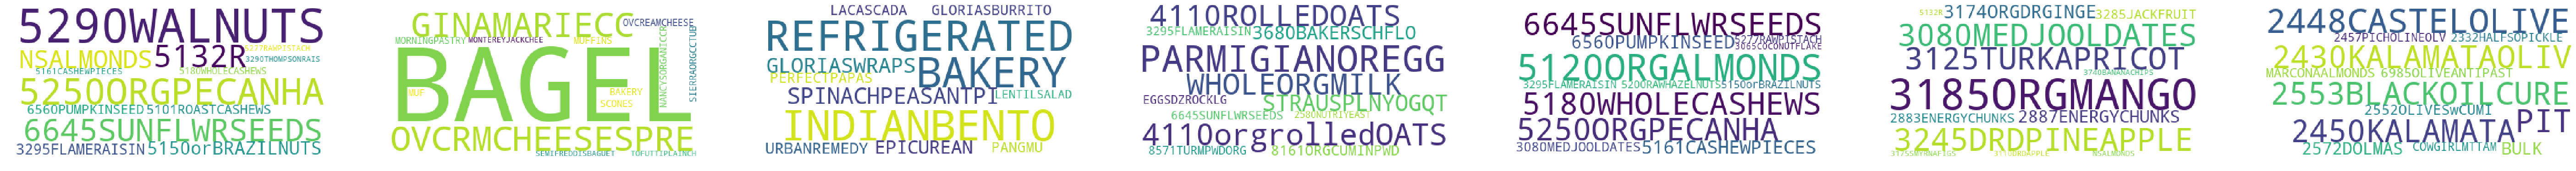

In [123]:
def print_top_items(model, feature_names, n_top_words):
    topic_dict = defaultdict()
    topics_list =[]
    fig = plt.figure(1,figsize=(100,100))
    for topic_idx, topic in enumerate(model.components_):
        print(topic_strength[topic_idx],"Topic #%d of %d:" %( topic_idx,number_of_components))
        #topic_string=(" ".join([feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]]))
        topic_string=[feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_dict[topic_idx]=topic_string
        topics_list.append(topic_string)
        print(topic_string)
        #print()
        wordcloud = WordCloud(max_font_size=500, max_words=1000, background_color="white").generate(str(topic_string).replace(" ", '').replace("'",""))
        #wordcloud = WordCloud(max_font_size=500, max_words=1000, background_color="white").generate(str(topic_string).replace("'","").replace(",",""))
        ax = fig.add_subplot(1,7,topic_idx+1)
        ax.imshow(wordcloud)
        ax.axis("off")
        # Display the generated image:
        #plt.figure(1,figsize=(10,10))
        '''plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()'''
        #plt.savefig('topic%d.png'%topic_idx)
        #plt.close()
        img_time=str(time.time()).split('.')[0]
        wordcloud.to_file('./img/2018/%s.topic%d.png'%(img_time,topic_idx))
        print('<img src="./img/2018/%s.topic%d.png">'%(img_time,topic_idx))
    return topic_dict,topics_list

topic_dict,topics_list = print_top_items(model,list(items_set),n_top_words)
print(topics_list)

In [124]:
topic_compare = np.zeros([len(topic_dict),len(topic_dict)])

for topic in topic_dict:
    for item in topic_dict[topic]:
        for topic2 in topic_dict:
            if item in topic_dict[topic2]:
                topic_compare[topic,topic2]+=1
print (topic_strength)            
print(topic_compare)


[0.05 0.03 0.03 0.83 0.02 0.02 0.02]
[[12.  0.  0.  2.  8.  1.  0.]
 [ 0. 12.  1.  0.  0.  0.  0.]
 [ 0.  1. 12.  0.  0.  0.  0.]
 [ 2.  0.  0. 12.  2.  0.  0.]
 [ 8.  0.  0.  2. 12.  1.  0.]
 [ 1.  0.  0.  0.  1. 12.  0.]
 [ 0.  0.  0.  0.  0.  0. 12.]]


In [125]:
list_of_topics=[]
for topic in topic_dict:
     list_of_topics.append(topic_dict[topic])

In [126]:
topic_matrix=np.array(topics_list).T
topic_matrix.shape

(12, 7)

In [127]:
pd.DataFrame(topic_matrix,columns=topic_strength)

,0.05,0.03,0.03,0.83,0.02,0.02,0.02
0,5290 WALNUTS,BAGEL,REFRIGERATED,PARMIGIANO REGG,5120 ORG ALMONDS,3185 ORG MANGO,2448 CASTEL OLIVE
1,5250 ORG PECAN HA,OV CRM CHEESE SPRE,BAKERY,4110org rolledOATS,5180 WHOLE CASHEWS,3080 MEDJOOL DATES,2553BLACK OIL CURE
2,6645 SUNFLWR SEEDS,GINA MARIE CC,INDIAN BENTO,WHOLE ORG MILK,5250 ORG PECAN HA,3245 DRD PINEAPPLE,2430 KALAMATA OLIV
3,5132 R/NS ALMONDS,OV CREAM CHEESE,SPINACH PEASANT PI,4110 ROLLED OATS,6645 SUNFLWR SEEDS,3125 TURK APRICOT,2450 KALAMATA-PIT
4,5150or BRAZIL NUTS,NANCY'S ORGANIC CR,GLORIA'S WRAPS,STRAUS PLN YOG QT,5161 CASHEW PIECES,3174 ORG DR GINGE,2572 DOLMAS
5,3295 FLAME RAISIN,MORNING PASTRY/MUF,EPICUREAN,3680 BAKERS CH FLO,6560 PUMPKIN SEED,2887 ENERGY CHUNKS,BULK
6,6560 PUMPKIN SEED,SIERRA ORG CC TUB,URBAN REMEDY,8161 ORG CUMIN PWD,3080 MEDJOOL DATES,2883 ENERGY CHUNKS,2552 OLIVES wCUMI
7,5101 ROAST CASHEWS,BAKERY,GLORIA'S BURRITO,6645 SUNFLWR SEEDS,5277 RAW PISTACH,3285JACK FRUIT,6985 OLIVEANTIPAST
8,5180 WHOLE CASHEWS,SCONES/MUFFINS,PANGMU,EGGS DZ ROCK LG,3295 FLAME RAISIN,3740 BANANA CHIPS,MARCONA ALMONDS
9,5161 CASHEW PIECES,SEMIFREDDIS BAGUET,LA CASCADA,3295 FLAME RAISIN,5200 RAW HAZELNUTS,5132 R/NS ALMONDS,2457 PICHOLINE OLV


In [117]:
topic_matrix=np.array(topics_list).T
print (topic_matrix.shape)
topic_df = pd.DataFrame(topic_matrix,columns=topic_strength)

(12, 7)


In [118]:
import tabulate 

In [119]:
print()
print(tabulate.tabulate(topic_df.values,topic_df.columns, tablefmt="pipe")) 


| 0.05               | 0.03               | 0.03               | 0.83               | 0.02               | 0.02               | 0.02               |
|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|
| 5290 WALNUTS       | BAGEL              | REFRIGERATED       | PARMIGIANO REGG    | 5120 ORG ALMONDS   | 3185 ORG MANGO     | 2448 CASTEL OLIVE  |
| 5250 ORG PECAN HA  | OV CRM CHEESE SPRE | BAKERY             | 4110org rolledOATS | 5180 WHOLE CASHEWS | 3080 MEDJOOL DATES | 2553BLACK OIL CURE |
| 6645 SUNFLWR SEEDS | GINA MARIE CC      | INDIAN BENTO       | WHOLE ORG MILK     | 5250 ORG PECAN HA  | 3245 DRD PINEAPPLE | 2430 KALAMATA OLIV |
| 5132 R/NS ALMONDS  | OV CREAM CHEESE    | SPINACH PEASANT PI | 4110 ROLLED OATS   | 6645 SUNFLWR SEEDS | 3125 TURK APRICOT  | 2450 KALAMATA-PIT  |
| 5150or BRAZIL NUTS | NANCY'S ORGANIC CR | GLORIA'S WRAPS     | STRAUS PLN YOG QT  | 5161 CASHEW PIECES 

In [ ]:
ingredients =np.array((len(topics),len(topics[0])))
for row in topics:
    print('row',row)
    for i,item in enumerate(topics[row]):
        if item not in topics[row]:
            print ('i',i,item)
            
        if item not in topics[0]:
            print ('iI',i,item)
        #ingredients[row:i]=item
ingredients

In [ ]:
len(ing_set)

In [ ]:
ing_index_dict = dict(zip(ing_set, range(len(ing_set))))

In [ ]:
ingredients=np.array(ingredients)
ingredients=ingredients.reshape(5,55)

In [ ]:
ingredients.shape

In [ ]:
ing_matrix=np.zeros(ingredients.shape)

In [ ]:
for row,col in enumerate(ingredients):
    for i,c in enumerate(col):
        #print(row,i,c)
        ing_matrix[row,i]=ing_index_dict[c]
ing_matrix

In [ ]:
ing_array=ing_index_dict.values()

ing_array

In [ ]:
for i in ing_matrix:
    print(ing_array==i)

In [ ]:
for ing_index_dict

In [60]:
def print_basket_contents(basket_id):
    basket=[]
    #print('+++++++++++++++++++++++next basket+++++++++++++++++')
    for items in df['items'][basket_id]:
        #for item in items:
        print("item:",items)
    #return basket
#print_basket_contents(1116)

In [61]:
def print_top_baskets(model, W, n_top_words):
    baskets = []
    for topic_idx, w in enumerate(W.T):
        basket_string=str([df['items'][i] for i in w.argsort()[:-n_top_words - 1:-1]])
        count = 0
        for i in w.argsort()[:-n_top_words - 1:-1]:
            count+=1
            print("++++++++++++++++++Topic #%d, basket #%d+++++++++++++++++++"%(topic_idx,count))
            print_basket_contents(i)
        #print_basket_contents([i for i in w.argsort()[:-n_top_words - 1:-1]])
        baskets.append(basket_string)
        #print(basket_string)
        #print()
        '''wordcloud = WordCloud(max_font_size=500, max_words=1000, background_color="white").generate(basket_string.replace(" ", "_").replace("'",""))

        # Display the generated image:
        #plt.figure(1,figsize=(10,10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        #plt.savefig('topic%d.png'%topic_idx)
        #plt.close()
        wordcloud.to_file('topic%d.png'%topic_idx)'''
print_top_baskets(model,W,10)

++++++++++++++++++Topic #0, basket #1+++++++++++++++++++
item: ['', 'PEACH', 11.68, 12]
item: ['', 'GOLD BAR', 2.12, 12]
item: ['', 'EGGPLANT GLOBE', 2.48, 12]
item: ['', 'NF-COCO MILK- SIMP', 2.99, 15]
item: ['', 'NF-COCO MILK- SIMP', 2.99, 15]
item: ['', 'CHARD RED', 1.99, 12]
item: ['', 'TOMATILLOS', 4.74, 12]
item: ['', '3715 GOJI GRANOLA', 8.48, 16]
item: ['', 'ONIONS GREEN', 0.99, 12]
item: ['', 'ONIONS GREEN', 0.99, 12]
item: ['', 'SQUASH ZUCCHINI', 3.0, 12]
item: ['', 'CUCUMBERS', 2.77, 12]
item: ['', 'CARROTS BUNCH', 2.99, 12]
item: ['', 'KALE DINO', 2.39, 12]
item: ['', 'CILANTRO', 1.5899999999999999, 12]
item: ['', 'CILANTRO', 1.5899999999999999, 12]
item: ['', 'WOODSTK EDAMAME po', 3.19, 19]
item: ['', 'STRAWBERRY LOOSE', 4.89, 12]
item: ['', 'TOMATO DRY FARM', 6.26, 12]
item: ['', 'WOODSTK GREEN PEAS', 3.19, 19]
item: ['', 'WOODSTK GREEN PEAS', 3.19, 19]
item: ['', 'CABBAGE RED', 2.44, 12]
item: ['', 'PLUOT/PLUM RED', 4.39, 12]
item: ['', 'HERBS BASIL', 2.49, 12]
item: [''

++++++++++++++++++Topic #1, basket #1+++++++++++++++++++
item: ['', 'ORGANIC VALLEY SLI', 6.29, 14]
item: ['', '4299 OAT CSN GRANO', 27.65, 16]
item: ['', 'EDEN PINTO BN 15oz', 2.39, 15]
item: ['', '5185 ORG R/S CASHE', 16.42, 16]
item: ['', 'ORG W CORN TORT', 3.39, 17]
item: ['', '5120 ORG ALMONDS', 20.98, 16]
item: ['', 'COOMBS DARK 12 OZ', 10.39, 15]
item: ['', 'EDEN BLACKBEANS 15', 2.39, 15]
item: ['', 'POMEGRANATE', 3.79, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['', 'HEALTH ADE PINK LA', 3.79, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['', 'BC BLUEBERRY YOGUR', 0.99, 13]
item: ['', 'LIGHT SODIUM TOMAT', 5.99, 15]
item: ['', 'LIGHT SODIUM TOMAT', 5.99, 15]
item: ['VD', 'LIGHT SODIUM TOMAT', -5.99, 15]
item: ['', 'PAC ALM CHOCO 4PK', 4.29, 15]
item: ['', 'NAPA-OLIVE OIL25oz', 9.99, 15]
item: ['', 'MONARI ORG BALSAMI', 5.99, 15]
item: ['', 'EDEN KIDNEY BEANS', 2.49, 15]
item: ['', 'EDEN KIDNEY BEANS', 2.49, 15]
item: ['', 'PELLEGRINO -750 ML', 2.19, 15]
item: ['',

++++++++++++++++++Topic #2, basket #1+++++++++++++++++++
item: ['', 'RIGATONI PASTA', 5.49, 15]
item: ['', 'G&B 85% DRK CHOC B', 3.69, 15]
item: ['', 'G&B 85% DRK CHOC B', 3.69, 15]
item: ['', 'ARUGULA LOOSE', 0.98, 12]
item: ['', 'BLACKBERRY PACK', 4.99, 12]
item: ['', 'GRAPES RED', 8.74, 12]
item: ['', 'EGGPLANT JPN/CHINE', 3.36, 12]
item: ['', 'GOLD BAR', 0.75, 12]
item: ['', 'BASIL C/S', 2.49, 12]
item: ['', 'BLUBERRIES PINT', 6.49, 12]
item: ['', 'NECTARINE', 3.74, 12]
item: ['', 'PLUOT/PLUM RED', 3.59, 12]
item: ['', "Anthony's Cookies", 2.75, 17]
item: ['', "Anthony's Cookies", 2.75, 17]
item: ['', "ANNIE'S SPREAD 7 O", 3.99, 14]
item: ['', '2448 CASTEL OLIVE', 3.69, 16]
item: ['', '8 OZ BIO TUB t3', 0.30000000000000004, 36]
item: ['', 'LEMONS MEYER', 3.77, 12]
item: ['', 'SEED FEAST BREAD', 6.99, 17]
item: ['', 'ONIONS WHITE', 0.59, 12]
item: ['', 'AVOCADOS HASS', 6.26, 12]
item: ['', 'TOMATO MIX HEIRLOO', 1.3, 12]
item: ['', 'LIMES', 0.76, 12]
item: ['', 'CHEESE', 1.7000000000

++++++++++++++++++Topic #3, basket #1+++++++++++++++++++
item: ['', 'EOLemon Soap', 8.1, 4]
item: ['', 'EO Lavender soap', 8.1, 4]
item: ['', '479 SEASLT CARAMEL', 3.59, 15]
item: ['', 'PEPPER PADRON', 2.49, 12]
item: ['', 'BELF FRESH RICOTTA', 4.89, 14]
item: ['', 'GF SPINACH TORTILL', 5.89, 17]
item: ['', 'LIL GEM LETTUCE', 11.11, 12]
item: ['', 'FLEUR DE RE', 13.99, 14]
item: ['', 'LIL GEM LETTUCE', 7.51, 12]
item: ['', '5290 WALNUTS', 7.89, 16]
item: ['', '3 GAL KITCHEN WAST', 5.49, 7]
item: ['', 'BOOKS', 4.95, 8]
item: ['', 'WNP ROLL WRAP', 8.99, 8]
item: ['', 'ESTHERS PRETZELS', 2.0, 17]
item: ['', 'APPLES FUJI', 4.51, 12]
item: ['', '5120 ORG ALMONDS', 8.99, 16]
item: ['', 'MUSHROOM OYSTER LS', 3.52, 12]
item: ['VD', 'MUSHROOM OYSTER LS', -3.52, 12]
item: ['', 'MUSHROOM MAITAKE P', 3.99, 12]
item: ['VD', 'MUSHROOM MAITAKE P', -3.99, 12]
item: ['', 'MUSHROOMS HON SHIM', 3.99, 12]
item: ['VD', 'MUSHROOMS HON SHIM', -3.99, 12]
item: ['', 'MUSHROOMS HON SHIM', 3.99, 12]
item: ['VD',

++++++++++++++++++Topic #4, basket #1+++++++++++++++++++
item: ['', 'GLORY BEE BIG BEAR', 14.69, 15]
item: ['', 'CHESTNUTS', 9.99, 15]
item: ['', 'ORGANIC BUTTERMILK', 4.25, 13]
item: ['', 'ORG 1LB BUTTER', 6.99, 13]
item: ['', 'STRAUS PLN YOG QT', 5.29, 13]
item: ['', 'CREME FRAICHE', 2.65, 13]
item: ['', 'PARMIGIANO REGG', 8.8, 14]
item: ['', 'SPROUTED FIRM TOFU', 2.39, 13]
item: ['', 'CARROTS BUNCH', 2.99, 12]
item: ['', 'CARROTS BUNCH', 2.99, 12]
item: ['MP', 'BAG CREDIT', -0.05, 23]
item: ['', '4110 ROLLED OATS', 0.98, 16]
item: ['', 'RADISHES RED/FRENC', 1.99, 12]
item: ['', 'GINGER', 1.05, 12]
item: ['', 'EGGPLANT GLOBE', 1.88, 12]
item: ['', 'ONIONS YELLOW', 1.3900000000000001, 12]
item: ['', 'Clover ORG cottchs', 4.59, 13]
item: ['', 'OSCAR WILDE CHED', 3.6, 14]
item: ['', 'RUMIANO ORG JACK', 5.69, 14]
item: ['', 'MAASDAMMER', 8.19, 14]
item: ['', 'ORG 2%  QT CLOVER', 2.89, 13]
item: ['', 'KARA-COCONUT CREAM', 1.3900000000000001, 15]
item: ['', 'KARA-COCONUT CREAM', 1.39000000

++++++++++++++++++Topic #5, basket #1+++++++++++++++++++
item: ['', 'Sunscreen 1oz', 3.6, 4]
item: ['', 'PERLAGE ORG PROSEC', 16.99, 10]
item: ['', 'Sabor Orig', 5.19, 15]
item: ['', 'LJ SSALT SNACK CHP', 2.89, 15]
item: ['', 'KETTLE-ORG.BBQ 5oz', 2.59, 15]
item: ['', 'KETTLE-orgSALT&VIN', 2.59, 15]
item: ['', 'KETTLE-ORG.SALT5oz', 2.59, 15]
item: ['', "NANCY'S 16oz SOUR", 3.99, 13]
item: ['', 'MGA Scalp shampoo', 14.7, 4]
item: ['', 'Giovanni Condition', 8.1, 4]
item: ['', 'CAFE FANNY GRANOLA', 7.39, 15]
item: ['', 'PEPPER CHILI', 0.84, 12]
item: ['', 'TOMATO MIX HEIRLOO', 7.41, 12]
item: ['', 'PEPPER CHILI', 0.9, 12]
item: ['', 'PEPPER CHILI', 0.72, 12]
item: ['', 'ONIONS RED', 1.16, 12]
item: ['', 'FH CLASSIC CARAWAY', 6.99, 13]
item: ['', 'POTATOES GARNET', 4.37, 12]
item: ['', 'GINGER', 1.65, 12]
item: ['', 'GARLIC WHITE', 2.8, 12]
item: ['', 'CUKE MEDIT/PERSIAN', 4.23, 12]
item: ['', 'SHALLOTS', 0.56, 12]
item: ['', 'LIL GEM LETTUCE', 5.83, 12]
item: ['', 'SHALLOTS', 0.8, 12]
ite

++++++++++++++++++Topic #6, basket #1+++++++++++++++++++
item: ['', 'STRAUS PLN YOG QT', 4.39, 13]
item: ['', 'ORG Whipping crm', 4.59, 13]
item: ['', 'ORG Whipping crm', 4.59, 13]
item: ['', 'SHALLOTS', 9.13, 12]
item: ['', 'ONIONS YELLOW', 1.01, 12]
item: ['', '5640 RICE BRAN OIL', 12.27, 16]
item: ['MP', 'BAG CREDIT', -0.05, 23]
item: ['', 'GALLON JAR t244', 7.49, 6]
item: ['', 'SQUASH ZUCCHINI', 6.89, 12]
item: ['', 'PEPPERS RED BELL', 7.53, 12]
item: ['', 'ONIONS YELLOW', 0.8300000000000001, 12]
item: ['', 'GOLD BAR', 2.6, 12]
item: ['', 'SQUASH SUNBURST', 1.55, 12]
item: ['', 'CROOK/STRAIGHT NEC', 2.24, 12]
item: ['', 'KING A.ALL-PURP5lb', 5.99, 15]
item: ['', 'NECTARINE', 9.58, 12]
item: ['', 'PLUOT/PLUM RED', 5.89, 12]
item: ['', 'LIMES', 4.07, 12]
item: ['', 'ENDIVE BELGIAN YEL', 4.18, 12]
item: ['', 'TOMATO DRY FARM', 14.56, 12]
item: ['', 'RADISHES RED/FRENC', 2.99, 12]
item: ['', 'RADISHES RED/FRENC', 2.99, 12]
item: ['', 'LEMONS', 10.38, 12]
item: ['', 'FRENCH FETA CHEESE'

In [ ]:
df['item_count'].max()

In [ ]:
W[:,1]

In [ ]:
n_top_words=10
for i,w in enumerate(W.T):
    print(i,w.argsort()[:-n_top_words - 1:-1])

In [ ]:
len(list(items_set))

In [ ]:
for topic in H:
    print (topic.argsort()[:-10-1:-1])

In [ ]:
feat
str([feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]])

In [ ]:
df.shape[0]
for i in range(10,11):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            print (it[1],it[2])

In [ ]:
df.shape[0]
for i in range(10,11):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            df[it[1]][i:i+1]=df[it[1]][i:i+1]+it[2]

In [ ]:
df['CILANTRO'][10:11]

In [ ]:
df.shape[0]
for i in range(1,df.shape[0]):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            df[it[1]][i:i+1]=df[it[1]][i:i+1]+it[2]

In [ ]:
df.shape

In [ ]:
df.to_pickle('02012019.pkl')

In [ ]:
len(items_set)

In [ ]:
trans = []
for a in df[1:2]['items']:
    #trans.append([r for v in a for r in v])
    trans.append(a)
print(a)

In [ ]:
trans =[]
for l in [i for i in df[1:2]['items']]:
    print (l)
    trans.append(l)
    print (trans)

In [ ]:
#pd.get_dummies([i for i in df[1:2]['items']]).values()

In [ ]:

type(df['items'].values)
count=0
for document in df['items'][1]:
    print (document)
    
    for word in(document):
        count+=1
        print (count,word)
        '''for letter in str(word):
            print (letter)'''

In [ ]:
df[['gross+','time']].plot()
plt.show()

In [ ]:
ff= './tlogs/201902'
if ff.startswith("./tlogs"):
    print ("yep")

In [ ]:
for f in os.walk('./tlogs'): print ("f:",f,"sub:",sub)


In [ ]:
import os

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        #print os.path.join(subdir, file)
        filepath = subdir + os.sep + file

        if filepath.endswith(".asm"):
            print (filepath)

In [ ]:
df=pd.read_pickle('02012019.pkl')

In [ ]:
df[df['BANANAS']!=0]

In [ ]:
df.columns

In [ ]:
plt.scatter(x=df['time'],y=df['gross+'])

In [ ]:
df.type='Va'

In [ ]:
def get_dataframe(filepath):

    all_files = glob.glob(os.path.join(filepath, "*.json"))
    df = pd.concat((pd.read_json(f,keep_default_dates=False,lines=True) for f in all_files)) 
    df=df[df['term']<10]
    df['date']=pd.to_datetime(df['date'],yearfirst=True)
    df['day_of_week']=df['date'].dt.day_name()
    df['month']=df['date'].dt.month
    return df

In [ ]:
path = '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/'
df = get_dataframe(path)

In [ ]:
all_files =[]
for f in range(0,366):
    all_files.append(path+"%d.json"%f)
print (all_files)

In [ ]:
import pandas as pd 
df = pd.concat((pd.read_json(f,keep_default_dates=False,lines=True) for f in all_files)) 

In [ ]:
df.info()

In [ ]:
plt.scatter(dfq1['item_count'],dfq1['term'])